In [11]:
import string
import numpy as np
import torch
import librosa

from faster_whisper import WhisperModel as FasterWhisperModel
from transformers import WhisperProcessor, WhisperModel


def whisper_char_timings(audio_path, model_size="tiny", device="cuda"):
    """
    使用 faster-whisper 提取逐字 onset 时间
    """
    chinese_punctuation = "，。！？；：「」『』（）【】《》〈〉、"
    all_punctuation = string.punctuation + chinese_punctuation

    model = FasterWhisperModel(model_size, device=device, compute_type="float16")
    segments, _ = model.transcribe(audio_path, word_timestamps=True, language="zh")

    char_list = []
    for seg in segments:
        for word in seg.words:
            text = word.word.strip()
            if not text:
                continue
            clean_text = ''.join(ch for ch in text if ch not in all_punctuation)
            if not clean_text:
                continue

            duration = word.end - word.start
            n_chars = len(clean_text)
            step = duration / n_chars

            for i in range(n_chars):
                onset = word.start + i * step
                char_list.append(onset)

    return char_list


def whisper_embeddings_full(audio_path, onsets, duration=0.2, model_name="openai/whisper-tiny"):
    """
    整段音频送入 Whisper encoder，再根据 onsets 截取 duration (默认200ms) 对应的 hidden states
    返回 dict:
        {
            "acoustic_embedding": (n_segments, d),
            "speech_embedding":   (n_segments, d)
        }
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperModel.from_pretrained(model_name).to(device)
    model.eval()

    # load 全音频
    y, _ = librosa.load(audio_path, sr=16000)

    # Whisper 要求输入长度固定为 3000（对应 30s），padding="max_length" 自动 pad
    inputs = processor(
        y, sampling_rate=16000, return_tensors="pt", padding="max_length"
    ).to(device)

    with torch.no_grad():
        encoder_outputs = model.encoder(inputs.input_features, output_hidden_states=True)
        hidden_states = encoder_outputs.hidden_states  # list of layer outputs

    seq_len = hidden_states[-1].shape[1]     # 1500
    audio_dur = len(y) / 16000               # 总时长(s)
    step_time = audio_dur / seq_len          # 每步对应的时间（≈20ms）

    acoustic_embeddings = []
    speech_embeddings = []

    half_window = duration / 2

    for onset in onsets:
        # 起止时间
        start_t, end_t = onset - half_window, onset + half_window
        start_idx = max(0, int(start_t / step_time))
        end_idx   = min(seq_len, int(end_t / step_time))

        # acoustic (第0层), speech (最后一层)
        acoustic_seg = hidden_states[0][0, start_idx:end_idx, :].mean(dim=0)
        speech_seg   = hidden_states[-1][0, start_idx:end_idx, :].mean(dim=0)

        acoustic_embeddings.append(acoustic_seg.cpu())
        speech_embeddings.append(speech_seg.cpu())

    return {
        "acoustic_embedding": torch.stack(acoustic_embeddings).numpy(),
        "speech_embedding": torch.stack(speech_embeddings).numpy(),
    }

In [14]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from math import atanh
from sklearn.decomposition import PCA

def encoding_model(eeg_data, embedding, split_ratio):
    n_tokens, n_channels, n_timepoints = eeg_data.shape
    assert embedding.shape[0] == n_tokens, "Number of tokens must match between EEG data and embeddings"
    
    # 使用PCA降维
    pca = PCA(n_components=50)
    embeddings_pca = pca.fit_transform(embedding)
    
    # 分割数据
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings_pca, eeg_data, test_size=1-split_ratio, random_state=42
    )
    
    alphas = np.logspace(-3, 3, 7)
    channel_correlations = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # 获取当前通道的所有时间点数据
        y_train_channel = y_train[:, channel_idx, :]
        y_test_channel = y_test[:, channel_idx, :]
        
        # 展平时间维度 (n_samples, n_timepoints)
        y_train_flat = y_train_channel.reshape(y_train_channel.shape[0], -1)
        y_test_flat = y_test_channel.reshape(y_test_channel.shape[0], -1)
        
        # 训练Ridge回归模型
        ridge = RidgeCV(alphas=alphas, store_cv_results=True)
        ridge.fit(X_train, y_train_flat)
        
        # 预测
        y_pred_flat = ridge.predict(X_test)
        
        # 将真实值和预测值展平为1D数组，计算整个通道的相关系数
        y_test_1d = y_test_flat.flatten()
        y_pred_1d = y_pred_flat.flatten()
        
        # 计算Pearson相关系数
        r, _ = pearsonr(y_test_1d, y_pred_1d)
        
        # Fisher Z变换（保持与Huth方法一致）
        if abs(r) >= 0.999:
            r = np.sign(r) * 0.999
        fisher_z = atanh(r)
        
        channel_correlations[channel_idx] = r
    
    return channel_correlations

In [33]:
import gc
import mne
import pandas as pd
import numpy as np

# 文件路径
eeg_tsv = "ChineseEEG/sub-01/ses-littleprince/sub-01_ses-littleprince_scans.tsv"
acq_df = pd.read_csv(eeg_tsv, sep="\t")
acq_files = acq_df["filename"]

# 存储所有 EEG 数据和 Embedding
all_eeg = []
all_acoustic = []
all_speech = []

for idx, acq in enumerate(acq_files[:5]):
    # 1. 读 EEG
    eeg_data_path = f"ChineseEEG/sub-01/ses-littleprince/{acq}"
    raw_data = mne.io.read_raw_brainvision(eeg_data_path, preload=True, verbose=False)
    data_array = raw_data.get_data()
    sfreq = raw_data.info["sfreq"]

    # 2. 取第一个 trigger 时间
    events, event_dict = mne.events_from_annotations(raw_data, verbose=False)
    first_trigger_sample = events[1, 0]
    first_trigger_time = first_trigger_sample / sfreq

    # 3. 对齐音频 onset
    audio_path = f"Audio/A1/audio_{idx}.wav"
    audio_onsets = whisper_char_timings(audio_path=audio_path)
    first_audio_onset = audio_onsets[0]
    time_lag = first_trigger_time - first_audio_onset
    eeg_aligned_onsets = [onset + time_lag for onset in audio_onsets]

    # 4. 切 EEG segment
    eeg_segments = []
    valid_indices = []
    for i, onset in enumerate(eeg_aligned_onsets):
        start_sample = int(onset * sfreq)
        end_sample = start_sample + 50  # 50 samples (~31ms at 1600Hz, ~100ms at 500Hz)

        if end_sample <= data_array.shape[1]:
            eeg_segment = data_array[:, start_sample:end_sample]  # (n_channels, 50)
            eeg_segments.append(eeg_segment)
            valid_indices.append(i)
        else:
            break

    if len(eeg_segments) == 0:
        continue

    eeg_data = np.stack(eeg_segments)  # (n_valid, n_channels, 50)
    all_eeg.append(eeg_data)

    # 5. 提取 Whisper embedding
    valid_audio_onsets = [audio_onsets[i] for i in valid_indices]
    embedding = whisper_embeddings_full(audio_path=audio_path, onsets=valid_audio_onsets, duration=0.2)

    all_acoustic.append(embedding["acoustic_embedding"])  # (n_valid, d)
    all_speech.append(embedding["speech_embedding"])      # (n_valid, d)

    gc.collect()

# 6. 合并
all_eeg = np.concatenate(all_eeg, axis=0).astype(np.float32)          # (N, n_channels, 50)
all_acoustic = np.concatenate(all_acoustic, axis=0).astype(np.float32) # (N, d)
all_speech = np.concatenate(all_speech, axis=0).astype(np.float32)     # (N, d)

print("EEG data:", all_eeg.shape)
print("Acoustic embeddings:", all_acoustic.shape)
print("Speech embeddings:", all_speech.shape)

C:\Users\FranR\.conda\envs\neuroimaging\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


EEG data: (2610, 128, 50)
Acoustic embeddings: (2610, 384)
Speech embeddings: (2610, 384)


In [36]:
acc = encoding_model(eeg_data = all_eeg, embedding= np.nan_to_num(all_acoustic,0), split_ratio=0.8)

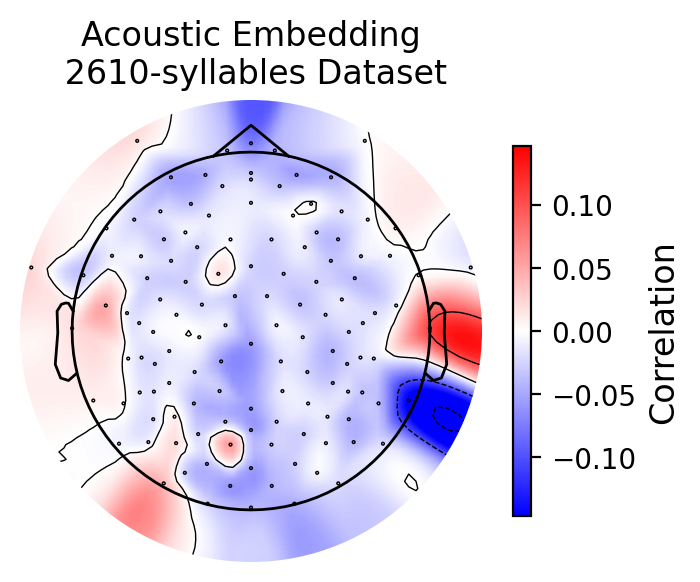

In [37]:
import pickle
info = pickle.load(open("info.pkl","rb"))
import mne.viz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

fig, ax = plt.subplots(figsize=(4, 3))
im = mne.viz.plot_topomap(acc_speech, info, ch_type='eeg', show=False, extrapolate="head", 
                         size=1.5, contours=3, cmap="bwr", axes=ax,
                         mask_params=dict(marker='o', markerfacecolor='k', 
                                         markeredgecolor='k', linewidth=0, markersize=6))
cbar = plt.colorbar(im[0], ax=ax, shrink=0.8)
cbar.set_label('Correlation', fontsize=12)
ax.set_title(f"Acoustic Embedding\n {all_eeg.shape[0]}-syllables Dataset")

plt.show()

In [38]:
acc_speech = encoding_model(eeg_data = all_eeg, embedding= np.nan_to_num(all_speech,0), split_ratio=0.8)

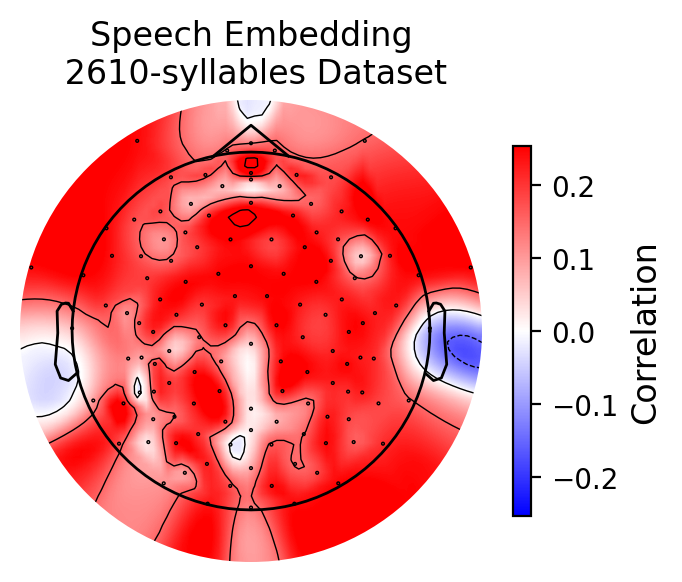

In [39]:
import pickle
info = pickle.load(open("info.pkl","rb"))
import mne.viz
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

fig, ax = plt.subplots(figsize=(4, 3))
im = mne.viz.plot_topomap(acc, info, ch_type='eeg', show=False, extrapolate="head", 
                         size=1.5, contours=3, cmap="bwr", axes=ax,
                         mask_params=dict(marker='o', markerfacecolor='k', 
                                         markeredgecolor='k', linewidth=0, markersize=6))
cbar = plt.colorbar(im[0], ax=ax, shrink=0.8)
cbar.set_label('Correlation', fontsize=12)
ax.set_title(f"Speech Embedding\n {all_eeg.shape[0]}-syllables Dataset")

plt.show()